# Library imports and parameters

In [1]:
import time, os, sys, shutil, pathlib, random, math, csv

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

import numpy as np
import scipy as sc
import seaborn as sns
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

from IPython import display
from IPython.display import Audio
from google.colab import drive
from pathlib import Path
from datetime import datetime

AUTOTUNE = tf.data.AUTOTUNE
seed = 69 #Sets the randomisation seed, in order to get the same RNG each session
tf.random.set_seed(seed)
np.random.seed(seed)


#Parameters
gdrive_path = Path("/content/gdrive/MyDrive/Datasets") / ("MSWC_dataset_wavs/MSWC_keywords_wavs.zip") #Path to the dataset with wav files consisting of the selected keywords(located in googleDrive)
modelSavePath = Path("/content/gdrive/MyDrive/Saved_models/")
modelType = "efficientNet" #CNN architecture that will be used: "simpleCNN", "mobileNetV1", "mobileNetV2" or "mobileNetV3" or "efficientNet"
alphaMobileNet = 0.7 #MobileNet architecture widht/complexity setting (Value from 0.1 to 1.0)
dropoutMobileNet = 0.005 #MobileNetV1 dropout setting (0.001 default)
datasetType = "MSWC" #Dataset that will be used: "MSWC" (Multilingual Spoken Word Corpus) or "GSC" (Google Speech Commands)

#Data augmentation parameters
data_augmentation_bool = False #Whether or not data augmentation will be performed on the TRAIN set
augmentation_chance = 0.25 #Percentage of files that are augmented

#Files can have the following augmentations: only time-shifted, only noise added, shifted and noise added. 
shift_audio_bool = True
shift_percentage = 0.5  #Percentage of the to be augmented files that are shifted in time
add_noise_bool = True
noise_percentage = 0.3  #Percentage of the to be augmented files that have noise added
desired_snr = 10 #Deisred SNR(Signal to Noise Ratio) for the noise to be added
normalize_spectrogram_bool = False #Whetether or not to normalize the output spectrogram to -1 and +1(Needed for MobileNet)


#Spectrogram parameters
make_3D_bool = True
sampleRate = 16000 #Sample rate of the audio files
sampleSegment = 142 #Window size of spectrogram in samples 
sampleHop = sampleSegment/2 #Hoplength of spectrogram in samples #133 gives square output
nfftSize = 446 #Size of the NFFT transformation, default is the sampleSegment
windowSpec = sc.signal.windows.hann(sampleSegment) #Spectrogram window that will be used

#Training parameters
EPOCHS = 10 #Amount of training cycles (Training may end earlier due to early stopping metrics)
batch_size = 64 #Amount of examples that are included in each batch that is used for training
#convNetName = ("V0.01_simpleCNN_Spectro_SNR" + str(desired_snr) + "_MSWC") #Name of model that will be saved into Google Drive

Check if certain Google Colab settings have been initialized(High-ram and GPU)

High-ram not needed, but GPU recommended due to massively reduced training time

In [2]:
from psutil import virtual_memory

device_name = tf.test.gpu_device_name()
print(device_name)

ram_gb = virtual_memory().total / 1e9 #Checks if the high RAM-runtime is enabled inside of Google Colab
print('Your runtime has {:.1f} gigabytes of available RAM'.format(ram_gb))
if ram_gb < 20:
  print('Not using a high-RAM runtime, go to Runtime -> Change runtime type -> Runtime shape -> High-Ram')
  print("High ram is not strictly neccesary")
else:
  print('You are using a high-RAM runtime!')

if device_name != '/device:GPU:0': #Checks if a GPU is enabled or used in Google Colab
  raise SystemError('GPU device not found(Training will be slower), to enable: go to Runtime -> Change runtime type -> Hardware accelerator: GPU')
print('Found GPU at: {}'.format(device_name))

/device:GPU:0
Your runtime has 27.3 gigabytes of available RAM
You are using a high-RAM runtime!
Found GPU at: /device:GPU:0


Mount Google Drive and download the dataset


In [3]:
#shutil.rmtree("/content/dataset")
try: 
  drive.mount('/content/gdrive', force_remount=False) #Initialize the Google Drive
  print("Google Drive succes!")
except:
  print("Error")

datasetPath = Path("/content/dataset")
if os.path.exists(datasetPath) != True: os.mkdir(datasetPath) #Make path if it doesn't exist

try:
  shutil.unpack_archive(gdrive_path, datasetPath, "zip") #Unpack the dataset .ZIP from google drive into the local machine
  print("Dataset unpacked from Gdrive and placed in: ", datasetPath)
except:
  print("Could not unpack dataset")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Google Drive succes!
Dataset unpacked from Gdrive and placed in:  /content/dataset


# Function decleration

Declaration of several helper functions

In [4]:
def load_filenames(commands, set): #Loads the filePaths of a SET
  filenames = []
  for item in commands:
    filenames = filenames + tf.io.gfile.glob(str(datasetPath / set / item) + "/*")
  print(len(filenames))
  shuffled_filnames = tf.random.shuffle(filenames) #Shuffle list in order to remove paterns
  return shuffled_filnames

def decode_audio(encoded_audio): #Decodes a wav file to the raw audio waveform, also makes sure that it is the right shape and size(16000 samples)
  decoded_audio, _ = tf.audio.decode_wav(contents=encoded_audio)
  decoded_audio = tf.squeeze(decoded_audio, axis=-1) #Remove stereo channel, make mono

  decoded_audio = decoded_audio[:sampleRate] #Remove excess samples if present
  zero_padding = tf.zeros([sampleRate] - tf.shape(decoded_audio), dtype=tf.float32)
  decoded_audio = tf.cast(decoded_audio, dtype=tf.float32) #Make sure that the audio is a 32-bit float
  equal_length_audio = tf.concat([decoded_audio, zero_padding], 0) #Pad audio with additional samples if shorter than 16000 samples
  return equal_length_audio

def wav_preProcessing(filePath): #Preprocesses a path to a file to a spectrogram and label_id
  label, set = get_label_from_path(filePath)
  label_id = get_label_id(label)

  audio_binary = tf.io.read_file(filePath)
  waveform = decode_audio(audio_binary)

  spectrogram = get_spectrogram(waveform)
  return spectrogram, label_id

def ds_preProcessing(set): #Preprocesses a set of files into a TF dataset object for training
  allFiles = load_filenames(commands, set)
  print("Amount of files in the set: ", len(allFiles))
  if set == "TRAIN" and data_augmentation_bool == True:
    data_augmentation(allFiles)
    allFiles = load_filenames(commands, set)

  files_ds = tf.data.Dataset.from_tensor_slices(allFiles) #Make dataset with only the filePaths of all the WAVs
  output_ds = files_ds.map(
      map_func=(lambda file_path: wav_preProcessing(file_path)), #Preprocess into a new dataset of spectrograms and labels
      num_parallel_calls=AUTOTUNE)
  
  if normalize_spectrogram_bool == True:
    normalized_ds = output_ds.map(
      map_func=(lambda spectrogram, label: normalize_spectrogram(spectrogram, label)), #Normalize spectrograms
      num_parallel_calls=AUTOTUNE)
    return normalized_ds
  else: return output_ds  

Get functions

In [5]:
def get_commands(ds_path): #Get all the available commands
  commands_dirs = sorted(os.listdir((ds_path / "TRAIN")))
  return commands_dirs

def get_label_from_path(filePath): #Gets the label of a wav file based on it's path
  splitPath = tf.strings.split(filePath, os.path.sep)
  label = splitPath[-2]
  set = splitPath[-3]
  return label, set

def get_label_id(label): #Gets the label_id, I.E a integer value of the label
  print(label)
  label_id = tf.argmax(label == commands)
  return label_id

def get_waveform_from_path(filePath): #Gets the raw audio of a wav path
  audio_binary = tf.io.read_file(filePath)
  waveform = decode_audio(audio_binary)
  return waveform

def get_spectrogram(audio): #Converts audio to a spectrogram
  #x_shape = math.ceil((sampleRate - sampleSegment) / (sampleHop*sampleRate)+1)
  #y_shape = 
  spectrogram = tf.py_function(__spectrogram__, [audio], tf.float32) #Tensorflow Py function for eager execution while being run by a dataset object, needed as the function otherwise crashes
  if make_3D_bool == True:
    spectrogram_3D = tf.stack([spectrogram, spectrogram, spectrogram], axis=-1)
    spectrogram_3D.set_shape((224 , 224, 3))
    return spectrogram_3D
  else:
    spectrogram = tf.expand_dims(spectrogram, -1) #Add dimension to spectrogram in order to make it (X x Y x 1), instead of (X x Y)
    spectrogram.set_shape((224 , 224, 1)) #Manually set the shape, as the py_function doesn't allow for shape data to be transfered.
  return spectrogram

def __spectrogram__(audio): #Helper function of get_spectrogram()
  _, _, spectrogram = sc.signal.spectrogram(audio, fs=sampleRate, nperseg=sampleSegment, noverlap=sampleHop, 
                                      nfft=nfftSize, mode="magnitude", window=windowSpec)
  return spectrogram

def get_spectrogram_plot(spectrogram): #Plots a spectrogram picture
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    if spectrogram.shape[2] == 1:
      spectrogram = tf.squeeze(spectrogram, axis=-1)
    elif spectrogram.shape[2] == 3:
      spectrogram, _, _ = tf.unstack(spectrogram, axis=-1)
    else: sys.exit("Error, invalid shape")
  plt.pcolormesh(spectrogram)
  plt.ylabel("Frequency")
  plt.xlabel("Time")
  plt.show()
  return

def get_audio_source(audio): #Gets the audio as a playable source
  display.display(display.Audio(audio, rate=16000))
  return

def get_audio_plot(audio, title="Raw wave "): #Gets an plot of the audio waveform
  fig = plt.figure(figsize=(14, 8))
  plt.title(title)
  plt.ylabel('Amplitude')
  plt.plot(np.linspace(0, 1, len(audio)), audio)
  plt.show()
  return

def get_model_name(): #Gets the next available model name
  modelFiles = os.listdir(modelSavePath)
  newestModelVersion = 0
  for index, modelFile in enumerate(modelFiles):
    fileVersion = tf.strings.split(modelFile, "_")[0] #Extract only the model version
    fileVersion = fileVersion.numpy().decode('utf-8') #Covert tensor to string
    if fileVersion[0] == "V": #Only check for model versions, not other files or directories
      fileVersion = float(fileVersion[1:]) #Covert to float and remove the V
      if fileVersion > newestModelVersion: newestModelVersion = fileVersion #Save highest model version
  modelVersion = newestModelVersion + 1

  currentTime = datetime.now() #Get current date
  dateModel = currentTime.strftime("%d/%m/%Y")
  dateModel = dateModel.replace("/", "-") #Replace backslashes with -, as it gives problems while making folders

  usedKeywords = ""
  for index, keyword in enumerate(commands): #Check for used keywords
    if index == 0: usedKeywords = "_" + str(keyword)
    else: usedKeywords = usedKeywords + "-" + str(keyword)

  modelName = "V" + str(modelVersion) + "_" + modelType + "_" + datasetType + usedKeywords + "_spectrogram_" + dateModel
  modelNameTFlite = "V" + str(modelVersion) + "_TFlite_" + modelType + "_" + datasetType + usedKeywords + "_spectrogram_" + dateModel
  return modelName, modelNameTFlite

Data augmentation functions

In [6]:
def check_for_silences(audio): #Checks if a audio file is mostly silent, if so it may be discarded

  return silence_status

def data_augmentation(filePathList): #Applies the data augmentation techniques to the training set
  print("Data augmentation", filePathList)
  augmented_files_path = datasetPath / "TRAIN"
  for index, filePath in enumerate(filePathList):
    if random.random() < augmentation_chance: #Don't augment all files, but rather a percentage o files
      audio_binary = tf.io.read_file(filePath)
      waveform = decode_audio(audio_binary)

      randomizer = random.random()
      if randomizer < shift_percentage: #Chooses between: Shifting, adding noise, shifting and noise addition. Based on their percentages that are set in the parameters
        #print("Shifting audio")
        waveform = shift_audio(waveform)
      elif randomizer < (noise_percentage + shift_percentage):
        #print("Adding noise")
        waveform = add_noise_to_audio(waveform)
      else:
        #print("Shifting and adding noise")
        waveform = shift_audio(waveform)
        waveform = add_noise_to_audio(waveform)

      word = tf.strings.split(filePath, os.path.sep)[4].numpy().decode('utf-8') #Save the new augmented sample as a new audio file(Easier to do this way)
      augmented_filename = "augmented_" + word + str(index) + ".wav"
      augmented_path = augmented_files_path / word / augmented_filename

      try:
        waveform = tf.expand_dims(waveform, -1) #Add stereo channel, as it can't be saved without it
        wav = tf.audio.encode_wav(waveform, sampleRate)
        tf.io.write_file(str(augmented_path), wav) #Save as WAV
      except:
        print("Path, samplerate is:", augmented_path, sampleRate)
        print("Waveform shape is:", waveform.shape)
        print("Unable to save .WAV!")
        sys.exit()
  return

def add_noise_to_audio(clean_audio): #Adds gaussian noise to the audio
  signal_watts = clean_audio ** 2
  signal_avg_watts = tf.math.reduce_mean(signal_watts)
  signal_avg_db = 10 * tf.math.log(signal_avg_watts) #Calculate average signal energy

  noise_avg_db = signal_avg_db - desired_snr
  noise_avg_watts = 10 ** (noise_avg_db / 10)
  mean_noise = 0
  noise_volts = tf.random.normal(shape=[len(signal_watts)], stddev=tf.math.sqrt(noise_avg_watts), dtype=tf.float32) #Make guassian noise distribution

  noised_audio = clean_audio + noise_volts #Add noise to audio
  return noised_audio

def shift_audio(audio): #Moves the audio in time direction via a circular window
  if random.randrange(2) == 0: #Randomly chooses either a positive or negative shift
    random_shift = random.uniform(-3,-0.2) #Pick a number of samples(*1000) between -3000 and -200 to shift the waveform with  
  else:                                    #This was chosen as the audio should always be shifted some amount(in this case 0,0125 sec) as otherwise it will just result in a duplicate training sample
    random_shift = random.uniform(0.2, 3)  #The other maximum, 3000 samples, was chosen as a larger number may cause the actual word itself to roll over to the end/beginning of the window

  random_shift_samples = math.ceil(random_shift * 1000)
  shifted_audio = tf.roll(audio, random_shift_samples, axis=0) #Moves the 1 second audio window with the random shift amount, rolls the excluded samples to the beginning/end
  return shifted_audio

def normalize_spectrogram(spectrogram, label=0):
  if normalize_spectrogram_bool != True or modelType == "mobileNetV3" : return spectrogram, label
  elif modelType == "mobileNetV1":
    normalized_spectrogram = tf.keras.applications.mobilenet.preprocess_input(spectrogram)
  elif modelType == "mobileNetV2":
    normalized_spectrogram = tf.keras.applications.mobilenet_v2.preprocess_input(spectrogram)
  else:
    normalized_spectrogram = tf.keras.applications.mobilenet.preprocess_input(spectrogram)
  return normalized_spectrogram, label

# Function verification
Tests in order to verify functions above

In [7]:
commands = get_commands(datasetPath)
allTestFiles = load_filenames(commands, "DEV")
print(commands)
for itteration, path in enumerate(allTestFiles):
  label_name, set_name = get_label_from_path(path)
  #print(path)
  #print("Label name is : ", label_name, "Set  name is: ", set_name)
  #print("Label id is: ", get_label_id(label_name).numpy())
  print()
  labelReadable = label_name.numpy().decode("utf-8")

  audio = get_waveform_from_path(path)
  #get_audio_plot(audio, ("Raw wave, " + labelReadable))
  #get_audio_source(audio)

  shifted_audio = shift_audio(audio)
  #get_audio_plot(shifted_audio, ("Shifted audio, " + labelReadable))
  #get_audio_source(shifted_audio)

  noisy_audio = add_noise_to_audio(audio)
  #get_audio_plot(noisy_audio, ("Noisified audio, " + labelReadable))
  #get_audio_source(noisy_audio)

  #sampleRate = 16000 #Sample rate of the audio files
#sampleSegment = 256 #Window size of spectrogram in samples
#sampleHop = 128 #Hoplength of spectrogram in samples
#nfftSize = sampleSegment #Size of the NFFT transformation, default is the sampleSegment
#windowSpec = sc.signal.windows.hann(sampleSegment) #Spectrogram window that will be used


  #_, _, spectrogram = sc.signal.spectrogram(audio, fs=sampleRate, nperseg=nperseg2, noverlap=(nperseg2/2), 
                                            #nfft=446, mode="magnitude", window=sc.signal.windows.hann(nperseg2))
  #print(spectrogram.shape)

  if itteration == 0: break

1003
['blue', 'red', 'unknown']



In [8]:
commands = get_commands(datasetPath)
print(get_model_name())

('V5.0_efficientNet_MSWC_blue-red-unknown_spectrogram_31-03-2022', 'V5.0_TFlite_efficientNet_MSWC_blue-red-unknown_spectrogram_31-03-2022')


In [9]:
commands = get_commands(datasetPath)
test_ds = ds_preProcessing("DEV")

allTestAugmentationFiles = load_filenames(commands, "TEMP")
for itteration, path in enumerate(allTestAugmentationFiles):
  label_name, set_name = get_label_from_path(path)
  print()
  labelReadable = label_name.numpy().decode("utf-8")

  audio = get_waveform_from_path(path)
  get_audio_plot(audio, ("Augmented audio, " + labelReadable))
  get_audio_source(audio)
  if itteration == 4: break

1003
Amount of files in the set:  1003
Tensor("strided_slice:0", shape=(), dtype=string)
0


# Dataset splits initialization
Creates dataset objects containing the splits of the dataset

7895
Amount of files in the set:  7895
Tensor("strided_slice:0", shape=(), dtype=string)
1003
Amount of files in the set:  1003
Tensor("strided_slice:0", shape=(), dtype=string)
1003
Amount of files in the set:  1003
Tensor("strided_slice:0", shape=(), dtype=string)
<ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


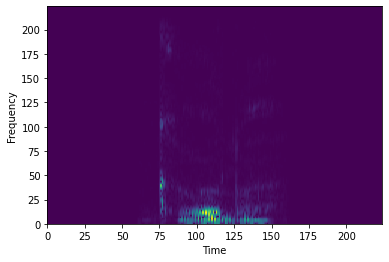

Minimum spectrogram tf.Tensor(1.8981289e-11, shape=(), dtype=float32) Maximum spectrogram value: tf.Tensor(0.00071528036, shape=(), dtype=float32)
tf.Tensor(2, shape=(), dtype=int64)


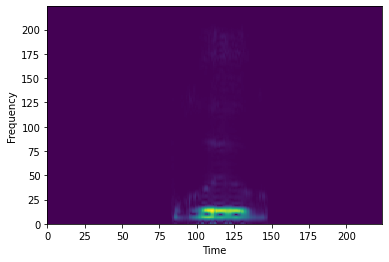

Minimum spectrogram tf.Tensor(1.8981289e-11, shape=(), dtype=float32) Maximum spectrogram value: tf.Tensor(0.008421855, shape=(), dtype=float32)
tf.Tensor(0, shape=(), dtype=int64)


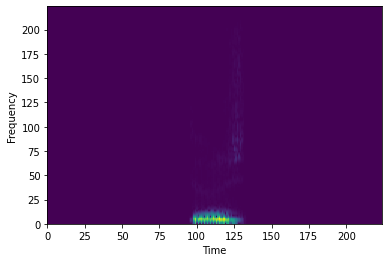

Minimum spectrogram tf.Tensor(1.8981289e-11, shape=(), dtype=float32) Maximum spectrogram value: tf.Tensor(0.0039767367, shape=(), dtype=float32)
tf.Tensor(2, shape=(), dtype=int64)


In [10]:
#shutil.rmtree("/content/dataset/DEV/unknown")
#shutil.rmtree("/content/dataset/TRAIN/unknown")
#shutil.rmtree("/content/dataset/TEST/unknown")

commands = get_commands(datasetPath)
train_ds = ds_preProcessing("TRAIN") #Initialize and make each dataset split
val_ds = ds_preProcessing("TEST")
test_ds = ds_preProcessing("DEV")

print(train_ds)

for spectrogram, label in test_ds.take(3): #show several spectrograms
  get_spectrogram_plot(spectrogram)
  print("Minimum spectrogram", tf.reduce_min(spectrogram), "Maximum spectrogram value:", tf.reduce_max(spectrogram))
  print(label)

# CNN model training

## Architecture decleration
Creates the CNN model architectures

In [11]:
for spectrogram, _ in test_ds.take(1): #Get spectrogram shape and number of labels
  input_shape = spectrogram.shape
  input_example = spectrogram
print('Input shape:', input_shape)
num_labels = len(commands)
print("Number of commands and ending parameters: ", num_labels)

if modelType == "simpleCNN": #Initialize simple CNN architecture if selected
  # Instantiate the `tf.keras.layers.Normalization` layer.
  norm_layer = layers.Normalization()
  # Fit the state of the layer to the spectrograms
  # with `Normalization.adapt`.
  norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))
  model = models.Sequential([
      layers.Input(shape=input_shape),
      # Downsample the input.
      layers.Resizing(32, 32),
      # Normalize.
      norm_layer,
      layers.Conv2D(32, 3, activation='relu'),
      layers.Conv2D(64, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.25),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(num_labels),
      ])
  print("Made an simpleCNN model!")

elif modelType == "mobileNetV1": #Initialize MobileNet architecture if selected
  model = tf.keras.applications.MobileNet(input_shape=input_shape, classes=num_labels, weights=None, 
                                          alpha=alphaMobileNet, dropout=dropoutMobileNet)
  print("Made an mobileNetV1 model!")

elif modelType == "mobileNetV2":
  model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=input_shape, classes=num_labels, weights=None,
                                                         alpha=alphaMobileNet)
  print("Made an mobileNetV2 model!")
elif modelType == "mobileNetV3":
  mobileNetLayers = tf.keras.applications.MobileNetV3Small(input_shape=input_shape, classes=num_labels, weights=None,
                                    minimalistic=False, include_preprocessing=normalize_spectrogram_bool, alpha=alphaMobileNet,
                                    include_top=False, pooling="avg", dropout_rate=0.4) #, pooling="avg"
  #for layer in mobileNetLayers.layers:
    #layer.trainable = True
  
  model = models.Sequential()
  model.add(mobileNetLayers)

  model.add(layers.Dropout(0.25))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(num_labels))

  #model.add(layers.Dense(256, use_bias=False))
  #model.add(layers.BatchNormalization())
  #model.add(layers.Activation('relu'))
  #model.add(layers.Dropout(0.3))
  #model.add(layers.Dense(num_labels))

  print("Made an mobileNetV3 model!")     
elif modelType == "efficientNet":
  model = tf.keras.applications.efficientnet.EfficientNetB0(input_shape=input_shape, weights=None, include_top=True, classes=num_labels, classifier_activation="relu")
  #for layer in effnet_layers.layers:
   # layer.trainable = True

  #model = models.Sequential()
  #model.add(effnet_layers)
    
  #model.add(layers.Dense(256))
  #model.add(layers.BatchNormalization())
  #model.add(layers.Activation('relu'))
  #model.add(layers.Dropout(0.5))
  #model.add(layers.Dense(num_labels))

  print("Made an efficientNet model!")   

else: print("Error, modeltype not set to valid model")

Input shape: (224, 224, 3)
Number of commands and ending parameters:  3
Made an efficientNet model!


## Metrics & Callbacks
Configures the metrics and settings of the model that are to be used for training

In [12]:
#Model settings
optimizer = tf.keras.optimizers.Adam() #Handles the weight itterations of the model during training; learning_rate=0.0001
#optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)
loss = tf.keras.losses.SparseCategoricalCrossentropy() #from_logits=True #How to calculate the loss of the model during training
metrics = [tf.keras.metrics.sparse_categorical_accuracy] #How to calculate the performance of the model

model.compile(optimizer=optimizer, loss=loss, metrics=metrics) #Create a usable model with all settings
model.summary()

#Training callback settings
weight_path="{}_weights.best.hdf5".format(modelType) #Path where to save the best weights
checkpoint = tf.keras.callbacks.ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, #Saves model weights during training when a new best is found
                             save_best_only=True, mode='min', save_weights_only = True) 
reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', #Reduces Learning rate when training stagnates, allows more training to take place
                                   factor=0.8, patience=2, 
                                   verbose=1, mode='auto', 
                                   min_delta=0.0001, cooldown=5, 
                                   min_lr=0.00001)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", #Stops training if the validation loss does not improve for 10 Epochs
                      mode="min", 
                      patience=5)
callback_list = [checkpoint, early, reduceLROnPlat] #Afforementioned functions that will be performed after each epoch

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

## Training
Training execution of the model

In [13]:
train_ds = train_ds.batch(batch_size) #Devides the splits into batches, improves training performance and speed
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE) #Preload the batches
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
if device_name == '/device:GPU:0':
  with tf.device('/device:GPU:0'): #Perform training with GPU device for faster training
    history = model.fit(
      train_ds, batch_size=batch_size,
      validation_data=val_ds,
      callbacks=[callback_list],
      epochs=EPOCHS, verbose=1)
else:
    history = model.fit(
      train_ds, batch_size=batch_size,
      validation_data=val_ds,
      callbacks=[callback_list],
      epochs=EPOCHS, verbose=1)

Epoch 1/10
124/124 [==============================] - ETA: 0s - loss: 4.1664 - sparse_categorical_accuracy: 0.3245
Epoch 1: val_loss improved from inf to 1.09861, saving model to efficientNet_weights.best.hdf5
124/124 [==============================] - 106s 770ms/step - loss: 4.1664 - sparse_categorical_accuracy: 0.3245 - val_loss: 1.0986 - val_sparse_categorical_accuracy: 0.2981 - lr: 0.0010
Epoch 2/10
124/124 [==============================] - ETA: 0s - loss: 1.4257 - sparse_categorical_accuracy: 0.3193
Epoch 2: val_loss did not improve from 1.09861
124/124 [==============================] - 51s 412ms/step - loss: 1.4257 - sparse_categorical_accuracy: 0.3193 - val_loss: 1.0986 - val_sparse_categorical_accuracy: 0.2981 - lr: 0.0010
Epoch 3/10
124/124 [==============================] - ETA: 0s - loss: 1.2255 - sparse_categorical_accuracy: 0.3098
Epoch 3: val_loss did not improve from 1.09861

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
124/124 [==========

## Performance
Analyse the performance of the trained model

Succesfully saved training graph


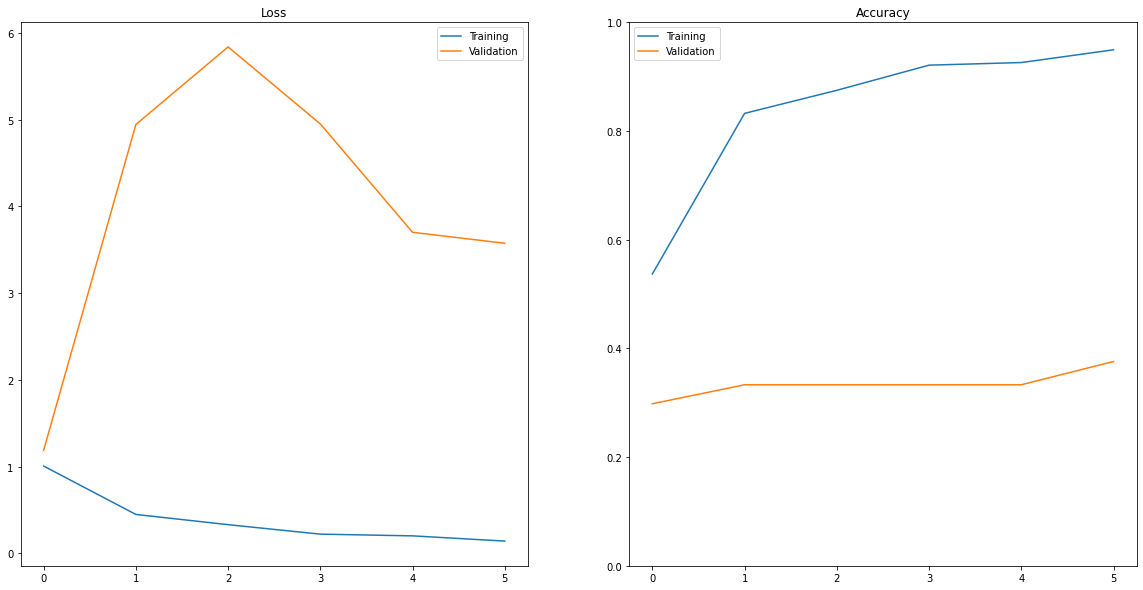

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10)) #Display losses and accuracy in a plot
ax1.plot(history.history['loss'], label='Training')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.legend()
ax1.set_title('Loss')
ax2.plot(history.history['sparse_categorical_accuracy'], label='Training')
ax2.plot(history.history['val_sparse_categorical_accuracy'], label='Validation')
ax2.legend()
ax2.set_title('Accuracy')
ax2.set_ylim(0, 1)

try:
  os.mkdir("/content/results")  #Save figure as PNG, in order to save as metadata later
  fig.savefig("/content/results/training_graph.png")
except:
  print("Failed to save history figures")

print("Succesfully saved training graph")

Labels:  (1003,)
Test set accuracy: 38%
Succesfully saved confusion matrix


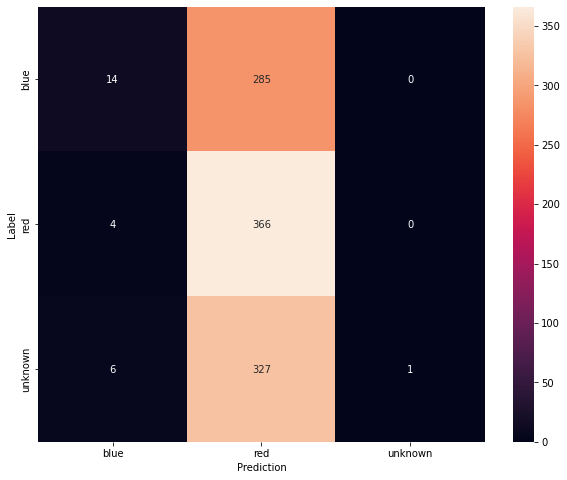

In [16]:
test_spectrogram = []
test_labels = []

for spectrogram, label in test_ds:  #Preload the test split
  test_spectrogram.append(spectrogram.numpy())
  test_labels.append(label.numpy())

test_spectrogram = np.array(test_spectrogram)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_spectrogram), axis=1) #Make predictions of the test split
y_true = test_labels
print("Labels: ", test_labels.shape)

test_acc = sum(y_pred == y_true) / len(y_true) #Calculate test split accuracy
print(f'Test set accuracy: {test_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) #Calculate confusion matrix based on predictions and true labels
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')

try:
  plt.savefig("/content/results/confusion_matrix.png") #Save confusion matrix as PNG
except:
  print("Failed to save confusion matrix")

print("Succesfully saved confusion matrix")
plt.show()

# Saving trained model
Saving the trained model to Google Drive, both in normal and TFLite versions.

In [ ]:
try: 
  drive.mount("/content/gdrive", force_remount=False) #Check if Google Drive is still mounted
  print("Google Drive succes!")
except:
  print("Error")

modelName, tfLiteModel_name = get_model_name() #Get next available model name, and create the name based on parameters

try:
  if os.path.exists(modelSavePath) != True: os.makedirs(modelSavePath)
  modelPath = "/content/gdrive/MyDrive/Saved_models/" + modelName
  model.save(filepath=modelPath, overwrite=False, save_format='tf') #Save model as normal TF model
except:
  print("Error")

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(modelPath) # path to the SavedModel directory
tflite_model = converter.convert()  #Convert normal TF model to TF Lite version

if os.path.exists(modelSavePath / "tfLite_models/") != True: os.makedirs(modelSavePath / "tfLite_models/") #Check if directory exists

# Save the model.
with open(tfLiteModel_name, 'wb') as f:
  f.write(tflite_model)

shutil.copyfile(tfLiteModel_name, (modelSavePath / "tfLite_models" / (tfLiteModel_name + ".tflite"))) #Move to GoogleDrive

In [ ]:
#Save model Meta Data

userComments = "3D spectrogram and bigger shape: 224x224, no augmentation"
#Comments from user to be saved in meta data

try:
  metaDataPath = (modelPath + "/metadata") #Move result pictures to the corresponding model in GoogleDrive
  os.mkdir(metaDataPath)
  shutil.move("/content/results/training_graph.png", (metaDataPath + "/training_graph.png"))
  shutil.move("/content/results/confusion_matrix.png", (metaDataPath + "/confusion_matrix.png"))
except:
  print("Could not create metadata directory in saved model")

if data_augmentation_bool != True: 
  augmentation_chance = 0 
  shift_percentage = 0 #Set chances to 0 if augmentation is not performed
  noise_percentage = 0 

headerMeta = ["ModelName", "Test split accuracy" , "CNN", "Dataset", "TF_Version", "Data augmentation percentage", "Time shift percentage", "Noise addition percentage",
              "Noise SNR", "Normalize Spectrogram", "Sample Rate", "Window length(Spectro)", "Hop length(Spectro)", "NFFT size", "Epochs", 
              "Batch size", "Comments"]

dataRowMeta = [modelName, test_acc, modelType, datasetType, str(tf. __version__), augmentation_chance, shift_percentage, noise_percentage,
           desired_snr, str(normalize_spectrogram_bool), sampleRate, sampleSegment, sampleHop, nfftSize, EPOCHS,
           batch_size, userComments]

with open((metaDataPath + "/metadata.csv"), 'w', encoding='UTF8') as f:
  writer = csv.writer(f)
  writer.writerow(headerMeta) #Save metadata as CSV in corresponding model
  writer.writerow(dataRowMeta)
print("Succesfully saved metadata CSV")